# Short and Long term wave loads on floating structure

Vprašanje je kako določimo neko stanje morja, ki bo reprezentativno za določeno območje za obdobje viharnega morja. Dobljene podatke nato vstavimo v program za določitev sil na privez. Z dobljenimi maximalnimi silami lahko dizajniramo ustrezen privez.


In [1]:
# Needed Python libs

import math as mat
import numpy as np
import matplotlib.pyplot as mpl

# MatPlotLib set LaTeX font
mpl.rcParams['text.usetex'] = True

## Modeliranje **Design sea**

Pri modeliranju "Design Sea" je potrebno določiti dva parametra
- *significant height* - $H_s$
- *zero crossing wave period* - $T_z$ (ponovitev dogodka)

Za praktično določitev statističnih podatkov uporabimo DNVGL priporočila
- DNVGL-RP-C205 "*Environmenal conditions and Environmental loads*" 
- DNVGL-CG-0130 "*Wave loads*"
- DNVGL-OS-E301 "*Position mooring*"

Potrebno je določiti *short-term* in *long-term* efekt, ki ga povzročata veter in pa oddaljeno mrtvo morje na višino vala. Tako je amplituda vala nato določena kot njun center

$$
H_s = \sqrt{H_{s,\mathrm{wind~sea}}^2 + H_{s,\mathrm{swell~sea}}^2}. 
$$

To višino nato lahko uporabimo v določitvi spektra s katerim izdelamo naključno morje za simulacijo.


### Weibull porazdelitev

Parametri ($\alpha_s$,$\beta_s$,$\gamma_s$) Weibull porazdelitev se nekako uporablja za določitev $H_s$ (**significant height**). Za primer vetra (*short term*) uporabimo 2-parametrično porazdelitev (\gamma_s=0)

Probability Density Function - **PDF**

$$
\mathrm{pdf}(h) = \frac{\beta_s}{\alpha_s} \left( \frac{h-\gamma_s}{\alpha_s}\right)^{\beta_s - 1} \exp \left[ -\left( \frac{h-\gamma_S}{\alpha_s}\right)^{\beta_s} \right]
$$

Cumulative Density Function - **CDF**

$$
\mathrm{cdf}(h) = 1 - \exp \left[ -\left( \frac{h-\gamma_s}{\alpha_s}\right)^{\beta_s} \right]
$$

Vrednosti $\alpha_s$, $\beta_s$ in $\gamma_s$ dobimo iz tabele C-1.

In [2]:
def Weibull(x,p):
    
    pdf = p[1]/p[0] * mat.pow((x-p[2])/p[0],p[1]-1) * mat.exp(-mat.pow((x-p[2])/p[0],p[1]))# PDF - Probability Density Function
    cdf = 1 - mat.exp(-mat.pow((x-p[2])/p[0],p[1])) # CDF - Cumulative Density Function
    
    return [pdf,cdf] 

### Log-Normal porazdelitev

Log-Normal porazdelitev se uporablja za določitev porazdelitve *long-term*, ki ga določa oddaljeno morje (swell). Tako dobimo pri določenem $H_s$ določeno "*zero-crossing wave*" periodo $T_z$

Probability Density Function - **PDF**

$$
\mathrm{pdf}(t) = \frac{1}{\sigma t \sqrt{2 \pi}} \exp \left[ \frac{(\ln t - \mu)^2}{2 \sigma^2} \right],
$$

kjer določimo

$$
\begin{split}
\mu & = a_0 + a_1 H_s^{a_2}, \\
\sigma & = b_0 + b_1 \exp(b_2 H_s).
\end{split}
$$

Vrednosti $a_0,a_1,a_2$ in $b_0,b_1,b_2$ dobimo iz tabele C-1.

Cumulative Density Function - **CDF**

$$
\mathrm{cdf}(t) = \frac{1}{2} \left[ 1 + \mathrm{Erf} \left( \frac{\ln t - \mu}{\sqrt{2}\sigma} \right) \right],
$$

kjer je $\mathrm{Erf}$ error function.

In [3]:
def LogNormal(x,p):
    
    m = p[0]+ p[1] * mat.pow(p[6],p[2])
    s = p[3] + p[4] * mat.exp(p[6]*p[5])
    
    pdf = mat.exp( -(mat.log(x) - m)**2 / (2*s**2)) / (x * s *mat.sqrt(2*mat.pi))
    cdf = 0.5 * ( 1 + mat.erf( (mat.log(x) - m)/(mat.sqrt(2)*s)) )
    
    return [pdf,cdf]

Primer:

Določi obe porazdelitvi za Nautical zone - **75**


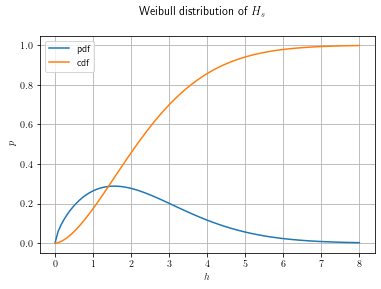

In [4]:
# Weibull - Nautical zone 75
nn = 100
x = np.linspace(0,8,nn)
pdf = np.zeros(nn)
cdf = np.zeros(nn)

a = 2.69
b = 1.67
g = 0.0
wp = [a,b,g] # Weibull parameters

for i in range(nn):
    [pdf[i], cdf[i]] = Weibull(x[i],wp)
    
fig, ax = mpl.subplots()
fig.suptitle('Weibull distribution of $H_s$')
ax.plot(x,pdf, label='pdf')
ax.plot(x,cdf, label='cdf')
ax.set_xlabel('$h$')
ax.set_ylabel('$p$')
ax.grid()
ax.legend()

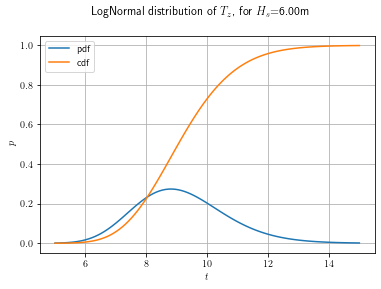

In [5]:
# LogNormal - Nautical zone 75
nn = 100
x = np.linspace(5,15,nn)
pdf = np.zeros(nn)
cdf = np.zeros(nn)

a0 = 0.70
a1 = 1.216
a2 = 0.118
b0 = 0.07
b1 = 0.0991
b2 = -0.0103
Hs = 6.0
lnp = [a0,a1,a2,b0,b1,b2,Hs] # LogNormal parameters

for i in range(nn):
    [pdf[i], cdf[i]] = LogNormal(x[i],lnp)
    
fig, ax = mpl.subplots()
fig.suptitle('LogNormal distribution of $T_z$, for $H_s$={:.2f}m'.format(Hs))
ax.plot(x,pdf, label='pdf')
ax.plot(x,cdf, label='cdf')
ax.set_xlabel('$t$')
ax.set_ylabel('$p$')
ax.grid()
ax.legend()

## Določitev **Metocean** konture z metodo IFORM (Inverse First Order Reliability Method) 


Metocean kontura določi pogoje za extremno stanje morja. Za valovno področje nas zanima določena letna kontura (recimo ekstremni val, ki se ponovi vsakih 100let - *Return period*; DNVGL: 50Y ali 100Y odvisno za strukturo, BV: 5 x "structure lifetime", in podobno glede na priporočjivo prakso klasifikacijskega zavoda), kjer določam nekaj urni razpon (1h,2h,3h,...) delovanja viharnega morja!

V prvem koraku je potrebno določiti verjetnost dogodka za izgubo (probability of failure) v iskanem časovnem oknu

$$
p_f = \frac{1}{365 \: \frac{24}{t_s} \: T_R},
$$

kjer je $t_s$ časovni interval vzorčenja valovanja (DNVGL Table C-{1,2,3} je $t_s=3$h), $T_R$ je pa ponovitev (return) dogodka (DNVGL ina ta $T_R=\{50,100\}$ let, odvisno od tipa strukture, za katero se vpliv valov računa).

Zanesljivost določimo kot $r_R = 1 - p_f$!

V naslednjemo koraku moramo poiskati vse parametre verjetnostnih porazdelitev ($\alpha_s, \beta_s, \gamma_s$ in $a_0,a_1,a_2,b_0,b_1,b_2$), ki jih dobimo iz DNVGL-RP-C205 - *Environmental conditions and environmental loads*.

Za določitev MetOcean konture potrebujemo parametrični prostor, kjer določimo krivuljo kot funkcijo parametra. Naš parametrični prostor $U=(u_1,u_2)$, ima tako oba parametra določena na krožnici. Tako lahko izrazimo en parameter z drugim. Radij krivulje dobimo s pomočjo verjetnosti $p_f$ ali $r_R$, ki sta določena iz Gaussove verjetnostne porazdelitve (verjetnost dokodkov je naključno porazdeljena). Gausova ali **Normalna** verjetnostna porazdelitev je:

Probability Density Function - **PDF**

$$
p(x) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left[ \frac{1}{2} \left( \frac{x-\mu}{\sigma}\right)^2 \right],
$$

kjer je $\mu$ povprečje in $\sigma$ standrdna devijacija.

Cumulative Density Function - **CDF**

$$
\Phi(x) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{-\infty}^x  \exp \left( -\frac{t^2}{2} \right) \: dt = \frac{1}{2} \left[ 1+ \mathrm{Erf} \left( \frac{x}{\sqrt{2}}\right) \right], 
$$

kjer je $\mathrm{Erf}$ error function in je določena z

$$
\mathrm{Erf}(x) = \frac{2}{\sqrt{\pi}} \int_{0}^x  \exp \left( -t^2 \right) \: dt,
$$

ki je standardna funkcija znotraj Python paketa. Poleg CDF potrebujemo tudi njen inverz $\Phi^{-1}$, ki ga imenujemo tudi **quantila** in ga označimo ponavadi kot $z_p = \Phi^{-1}(p)$. Enako je tudi ta funkcija del Python paketa. 

V našem parametričnem prostoru imamo tako določen radij $\beta$ z

$$
\Phi^{-1}(r_R) = \beta = \sqrt{u_1^2 + u_2^2}.
$$

Če variramo en parameter, recimo $u_1$ lahko iz pogoja določimo parameter $u_2$. Tako dobimo verjetnosti za

$$
p_1 = \Phi(u_1), ~~ \mathrm{in} ~~ p_2 = \Phi(u_2), 
$$

ki  pa sta vhodna podatka za iskanje $t_z$ in pa $H_s$ skozi Weibull in LogNormal porazdelitve. Tukaj je potrebno rešitev poiskati numerično, saj imamo podane verjetnosti iščemo pa vhodne spremenljivke.


## Primer izračuna: *Navtična zona 75*

Za opazovanja na vsakih 3 ure je kontura za 100 letni povratni ciklus določena z

$$
p_f = \frac{1}{365 \: \frac{24}{3} \: 100} = 3.42 \: 10^{-6}.
$$

Za Wibull porazdelitev so dani podatki

 - $\alpha_s = 2.69$
 - $\beta_s = 1.67$
 - $\gamma_s = 0.0$
 
Z LogNormal porazdelitev so dani podatki

 - $a_0=0.70$, $a_1=2.116$, $a_2=1.212$
 - $b_0=0.07$, $b_1=0.0991$, $b_2=-0.0103$


In [6]:
from scipy.stats import norm
from scipy.interpolate import interp1d

def find_Hs(p,c):
    dh = 0.5
    h = 0.0
    cdf = 0.0
    s0 = cdf-p
    
    while mat.fabs(cdf-p) > 1e-10:
        pP = Weibull(h,c)
        cdf = pP[1]
        s1 = cdf-p
        if ( s0*s1 < 0):
            dh = -0.5*dh
        h += dh
        s0 = s1
    
    return h
    
def find_Tz(p,c):
    dt = 1
    t = 1
    cdf = 0.0
    s0 = cdf-p
    
    while mat.fabs(cdf-p) > 1e-10:
        pP = LogNormal(t,c)
        cdf = pP[1]
        s1 = cdf-p
        if ( s0*s1 < 0):
            dt = -0.5*dt
        t += dt
        s0 = s1
    
    return t

In [7]:
def getMetOceanContour(ts,TR,wp,lnp):
    
    pf = ts / (365*24*TR)
    beta = norm.ppf(1-pf)
    #print('beta={:.5f}'.format(beta))
    
    # u1 in u2 ležita na krožnici z radijem beta
    nn = 200
    phi = np.linspace(0,2*mat.pi,nn) 
    u1 = beta*np.sin(phi)
    u2 = beta*np.cos(phi)

    p1 = norm.cdf(u1)
    p2 = norm.cdf(u2)
    
    # določi Hs za iskane verjetnosti
    Hs = np.zeros(nn)
    for i in range(nn):
        Hs[i] = find_Hs(p1[i],wp)
        # print('i={:d}, Hs={:.5g}'.format(i,Hs[i]))
    
    # določi Tz za iskano verjetnost pri Hs
    Tz = np.zeros(nn)
    for i in range(nn):
        lnp[6] = Hs[i]
        Tz[i] = find_Tz(p2[i],lnp)
        # print('i={:d}, Hs={:.5g}, Tz={:.5g}'.format(i,Hs[i],Tz[i]))
    
    return [Tz,Hs]

In [8]:
# Izračun MetOcean konture

ts = 3 # wave sampling rate
Tr = [6/8640,12/8640,1/360,15/360,1/12,1/2,1,10,30,50,100,10000] # return period
wp = [2.69, 1.67, 0] # Weibull parametri za NZ-75 [a,b,g]
lnp = [0.70,2.166,0.118,0.07,0.0991,-0.0103,0] # LogNormal parametri za NZ-75 [a0,a1,a2,b0,b1,b2,Hs]

data = []
for T in Tr:
    [Tz,Hs] = getMetOceanContour(ts,T,wp,lnp)
    data.append([Tz,Hs,T])

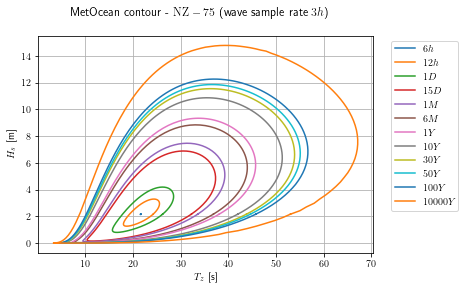

In [9]:
fig, ax = mpl.subplots()

fig.suptitle(r'MetOcean contour - $\mathrm{NZ}-75$ (wave sample rate $3h$)')
for d in data:
    if d[2] < 1.0:
        if d[2] < 1.0/12:
            if d[2] < 1.0/360:
                ax.plot(d[0],d[1], label=r'${:d}h$'.format(int(d[2]*8640)))
            else:
                ax.plot(d[0],d[1], label=r'${:d}D$'.format(int(d[2]*360)))
        else:
            ax.plot(d[0],d[1], label=r'${:d}M$'.format(int(d[2]*12)))
    else:
       ax.plot(d[0],d[1], label=r'${:d}Y$'.format(d[2]))
    
ax.set_xlabel('$T_z$ [s]')
ax.set_ylabel('$H_s$ [m]')
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#ax.legend()
ax.grid()

fig.savefig('metocean_contour.pdf', bbox_inches='tight')

Ocena verjetnosti za preživetje neke strukture, ki je dizajnirana za obobje $n=20$ let, kjer je bilo vzeto obdobje za ponovitev dogodka $T_R=100$ let, je določena s Poissonovo porazdelitvijo

$$
p_r(t) = \exp(-t/T_R) ~~~, ~ p_r(20) = 1 - \exp(-20/100) \approx 82\%
$$

kjer je $t$ čas operativnega delovanja strukture podan v letih.

**Opomba:** Poissonova porazdelitev ponazarja ponovitev nekega redkega dogodka v časovnem obdobju, ki je določeno z enim parametrom, to je prvim momentom porazdelitve (povprečjem).

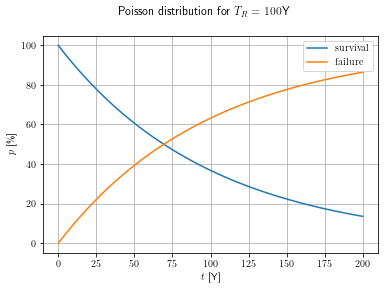

In [10]:
TR = 100
t = np.linspace(0,200,100)
pr = np.exp(-t/TR)
pf = 1 - pr

fig, ax = mpl.subplots()
fig.suptitle('Poisson distribution for $T_R=100$Y')
ax.plot(t,pr*100, label='$\mathrm{survival}$')
ax.plot(t,pf*100, label='$\mathrm{failure}$')
ax.set_xlabel(r'$t$ [Y]')
ax.set_ylabel(r'$p$ [\%]')
ax.grid()
ax.legend()

fig.savefig('probability_failure_survival.pdf', bbox_inches='tight')